## JV curves analyisis using NOMAD data

## Step 1 - Import the required functions 

In [16]:
import sys
sys.path.append("../Electrochemical_analysis") 
from nomad_api_calls import *
import os
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests
import seaborn as sns


In [17]:

## Plotting preferences 
# HZB colormap + extra colors
color_cm = ["#004f84ff", "#6cabe9ff", "#d15e57ff", "#ff7f2aff","#808080ff","#8787deff","#00a591ff", "#b2df8aff", "#f9c74fff", "#178eaeff", "#a70d88ff", "#373438ff","#004f84ff", "#6cabe9ff", "#d15e57ff", "#ff7f2aff","#808080ff","#8787deff","#00a591ff", "#b2df8aff", "#f9c74fff", "#178eaeff", "#a70d88ff", "#373438ff"]

matplotlib.rc('font', family='Liberation Sans', size=14)
matplotlib.rc('font', size= 14) # controls default text sizes
matplotlib.rc('axes', titlesize=14) # fontsize of the axes title
matplotlib.rc('axes', labelsize=14) # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=14) # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=14) # fontsize of the tick labels
matplotlib.rc('legend', fontsize= 10) # legend fontsize
matplotlib.rc('figure', titlesize=14) # fontsize of the figure title

%matplotlib widget


## Step 2 - Login to your NOMAD account 

In [18]:
url = "https://nomad-hzb-se.de/nomad-oasis/api/v1"
token = os.environ['NOMAD_CLIENT_ACCESS_TOKEN'] 
if len(token) > 10:
    print("Token Received")

Token Received


## Step 3 - Download the required data from NOMAD based on the batch name

In [19]:
batch_list="HZB_Echem_162_1"           # ✅ Input the batch that you want to analyze  

sample_list=get_ids_in_batch(url, token,batch_list, batch_type="HySprint_Batch")                 # Download the samples name from a designed batch 

dataJV=get_specific_data_of_samples_all(url, token, sample_list,  "HySprint_JVmeasurement")      # This function use the sample IDs to search for the NOMAD for impedance data
description = get_sample_description(url, token, sample_list) 


## Step 4 - Create a dataframe based on the sample description and JV curve data

In [21]:

rows = []

for idx, entry in enumerate(dataJV):                           
    lab_id = entry["samples"][0]["lab_id"]
    condition = description.get(lab_id)

    for curve in entry.get("jv_curve", []):
        cell_name = curve.get("cell_name", "")

        if "_for" in cell_name:
            direction = "Forward"
        elif "_rev" in cell_name:
            direction = "Reverse"
        else:
            continue  # skip curves that are neither forward nor reverse

        J = np.array(curve["current_density"]) 
        V = np.array(curve["voltage"])

        mask = J <= 28  # adjust threshold as needed
        V = V[mask]
        J = J[mask]

        rows.append({
            "lab_id": lab_id,
            "condition": condition,
            "direction": direction,
            "cell": cell_name[0],  # keep your original logic
            "PCE(%)": curve.get("efficiency"),
            "Voc(V)": curve.get("open_circuit_voltage"),
            "Jsc(mA/cm2)": curve.get("short_circuit_current_density"),
            "FF(%)":  curve.get("fill_factor"),
            "N_Rs": curve.get("series_resistance")*1e3,
            "N_Rsh": curve.get("shunt_resistance")*1e3,
            "Voltage(V)": V,
            "Current(mA/cm2)":J
        })

    # If you truly want ONLY the first entry, keep this break.
    # Otherwise, remove it.
    # break

df_exp = pd.DataFrame(rows, columns=[
    "lab_id", "condition", "direction", "cell", "PCE(%)", "Voc(V)", "Jsc(mA/cm2)", "FF(%)", "N_Rs","N_Rsh","Voltage(V)","Current(mA/cm2)"
])



## Step 5 - Do a Boxplot based on the description of the different conditions 

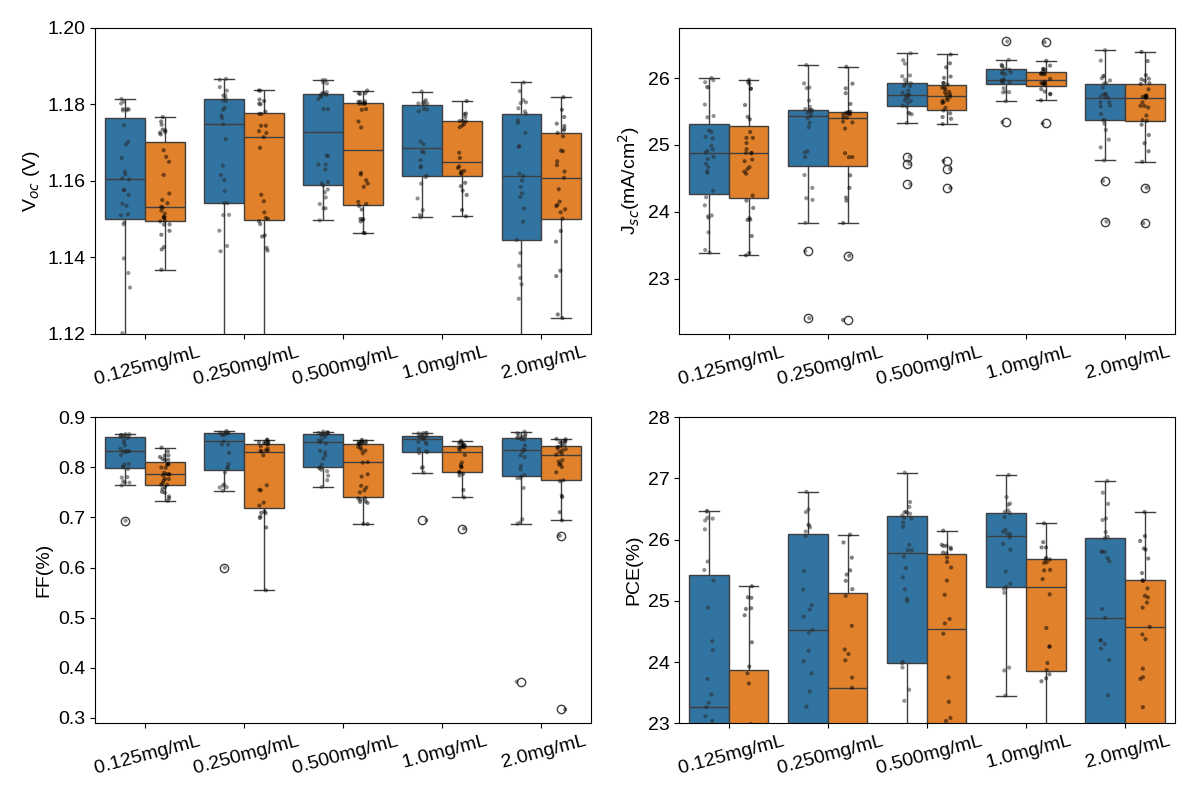

In [22]:
# Import dataframe
data=df_exp

# This lines are intended to reorganize the data according to the experiment
data["condition"] = data["condition"].str.replace("Ph4PACz:", "")          # This line remove the extra text from the description
condition_order = [" 0.125mg/mL"," 0.250mg/mL"," 0.500mg/mL"," 1.0mg/mL"," 2.0mg/mL"]  # Here I define the order that I want in my plot based on the data description

# Apply filters or operation on the data
data = data[data["PCE(%)"] > 5]

# keep only the two directions you care about
data_voc = data[data["direction"].isin(["Reverse", "Forward"])]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs_flat = axs.flatten()

# ---------- VOC PANEL ONLY ----------
ax = axs_flat[0]

# boxplots: one box per direction in each condition
sns.boxplot(x="condition",y="Voc(V)",hue="direction",data=data_voc, order=condition_order,
    hue_order=["Reverse", "Forward"], ax=ax, palette={"Reverse": "tab:blue", "Forward": "tab:orange"}  # or your color_array
)

# optional: points on top, split by direction as well
sns.stripplot(x="condition",y="Voc(V)",hue="direction",data=data_voc,order=condition_order,
    hue_order=["Reverse", "Forward"], dodge=True, ax=ax, color="black",  size=3,
    alpha=0.5,    legend=False,  # don't add a second legend from stripplot
)
ax.set_xlabel("")
ax.set_ylabel("V$_{oc}$ (V)")
ax.tick_params(axis="x", rotation=15)
ax.set_ylim([1.12, 1.20])
ax.legend_.remove()  # remove per-axes legend
# move legend somewhere nice (optional)


# ---------- Jsc PANEL ONLY ----------
ax = axs_flat[1]

# boxplots: one box per direction in each condition
sns.boxplot(x="condition",y="Jsc(mA/cm2)",hue="direction",data=data_voc, order=condition_order,
    hue_order=["Reverse", "Forward"], ax=ax, palette={"Reverse": "tab:blue", "Forward": "tab:orange"}  # or your color_array
)

# optional: points on top, split by direction as well
sns.stripplot(x="condition",y="Jsc(mA/cm2)",hue="direction",data=data_voc,order=condition_order,
    hue_order=["Reverse", "Forward"], dodge=True, ax=ax, color="black",  size=3,
    alpha=0.5,    legend=False,  # don't add a second legend from stripplot
)
ax.set_xlabel("")
ax.set_ylabel("J$_{sc}$(mA/cm$^2$)")
ax.tick_params(axis="x", rotation=15)
ax.legend_.remove()  # remove per-axes legend
#ax.set_ylim([22,27])


# ---------- FF PANEL ONLY ----------
ax = axs_flat[2]

# boxplots: one box per direction in each condition
sns.boxplot(x="condition",y="FF(%)",hue="direction",data=data_voc, order=condition_order,
    hue_order=["Reverse", "Forward"], ax=ax, palette={"Reverse": "tab:blue", "Forward": "tab:orange"}  # or your color_array
)

# optional: points on top, split by direction as well
sns.stripplot(x="condition",y="FF(%)",hue="direction",data=data_voc,order=condition_order,
    hue_order=["Reverse", "Forward"], dodge=True, ax=ax, color="black",  size=3,
    alpha=0.5,    legend=False,  # don't add a second legend from stripplot
)
ax.set_xlabel("")
ax.set_ylabel("FF(%)")
ax.tick_params(axis="x", rotation=15)
ax.legend_.remove()  # remove per-axes legend
#ax.set_ylim([70,90])
# move legend somewhere nice (optional)
#ax.legend(title="Direction", loc="upper right")


# ---------- PCE% PANEL ONLY ----------
ax = axs_flat[3]

# boxplots: one box per direction in each condition
sns.boxplot(x="condition",y="PCE(%)",hue="direction",data=data_voc, order=condition_order,
    hue_order=["Reverse", "Forward"], ax=ax, palette={"Reverse": "tab:blue", "Forward": "tab:orange"}  # or your color_array
)

# optional: points on top, split by direction as well
sns.stripplot(x="condition",y="PCE(%)",hue="direction",data=data_voc,order=condition_order,
    hue_order=["Reverse", "Forward"], dodge=True, ax=ax, color="black",  size=3,
    alpha=0.5,    legend=False,  # don't add a second legend from stripplot
)
ax.set_xlabel("")
ax.set_ylabel("PCE(%)")
ax.tick_params(axis="x", rotation=15)
ax.set_ylim([23,28])
ax.legend_.remove()  # remove per-axes legend
# move legend somewhere nice (optional)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,labels,
    loc="upper center",
    ncol=len(labels),              # puts legend items in one row
    bbox_to_anchor=(0.5, 1.05),    # slightly above the plot
    frameon=False
)

plt.tight_layout()
plt.savefig("PV_boxplots_with_directions.svg")

plt.show()


## Step 6 - Do a plot of the JV curves based on the median average 

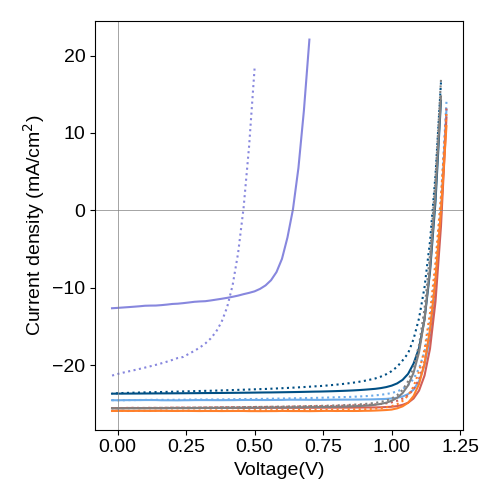

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))

style_map = {"Reverse": "-", "Forward": ":"}  # solid vs dotted
counter=0
for cond, group in data.groupby("condition"):
    # 1) pick the representative row (your median logic)
    med = group["PCE(%)"].median()
    idx = (group["PCE(%)"] - med).abs().idxmin()

    # 2) identify the device from that row
    lab_id = group.loc[idx, "lab_id"]
    cell   = group.loc[idx, "cell"]
    
    # 3) fetch BOTH directions for that same device within the condition
    dev = group[(group["lab_id"] == lab_id) & (group["cell"] == cell)]

    # 4) plot reverse + forward with different linestyles
    for direction, g2 in dev.groupby("direction"):
        V = g2.iloc[0]["Voltage(V)"]
        J = g2.iloc[0]["Current(mA/cm2)"]
        ax.plot(V, J,color=color_cm[counter] ,linestyle=style_map.get(direction, "-"),
                label=f"{cond} | {direction}")

    # 5) Change the counter used for the color plotting
    counter=counter+1
    
ax.set_xlabel("Voltage(V)")
ax.set_ylabel("Current density (mA/cm$^2$)")
ax.axhline(y=0, color="grey", lw=0.5)
ax.axvline(x=0, color="grey", lw=0.5)

plt.tight_layout()
plt.show()
